The project focuses on creating a sentiment analysis system and a basic recommendation system using Amazon product reviews. The goal is to analyze the emotions expressed in customer reviews (positive or negative) and predict sentiments using machine learning techniques. To achieve this, we preprocess the data, visualize common words, apply sentiment analysis with the Vader Sentiment Analyzer, and build a classification model using Logistic Regression. The project also includes text vectorization using TF-IDF to convert text into numerical features that the model can understand. Additionally, we demonstrate how a recommendation system can provide personalized suggestions based on user preferences.

In [26]:

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Library Installation & Import**




In [27]:
!pip install nltk
!pip install textblob
!pip install wordcloud

**IMPORTING NECESSARY LIBRARIES**

In [28]:
import matplotlib.pyplot as plt
from warnings import filterwarnings
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from textblob import Word, TextBlob
from wordcloud import WordCloud
import string
import nltk

**libraries used and their use **

**Pandas and NumPy:** For data handling and manipulation.

**Matplotlib**: For visualization (e.g., word clouds).

**nltk (Natural Language Toolkit):**
Provides tools like stopwords, SentimentIntensityAnalyzer, and tokenization.

**TextBlob:** For text lemmatization (simplifying words to their base form).

**WordCloud:** To create visualizations of text data.

**LogisticRegression:** A classification algorithm for sentiment prediction.

**TfidfVectorizer:** To convert text into numerical features for the model.

In [29]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("vader_lexicon")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**IMPORTING DATASETS**

In [30]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

RENAMING COLUMN

In [31]:
train.columns = ["polarity","title", "text"]
train.drop(["polarity"],
           axis=1,
           inplace = True)
train = train.sample(300000,
                     random_state = 99)  #TOOK A SAMPLE FOR FASTER PROCESSING.
train.head()

,title,text
2136295,Making a suit of human skin is hard work. Real...,"Yes, go ahead and laugh. But some of the other..."
2620775,If Only Amazon allowed my 6 *s.,"Wow,This movie is a classic. Family movie by a..."
1588872,I THOUGHT APPLE WAS USER FRIENDLY,I THOUGHT APPLE WAS USER FRIENDLY???????? I GU...
3125694,Very Helpful,I bought this book after joining Curves. It he...
1668956,Academically Repugnant,The first ten minutes of the film passed with ...


in above step The dataset is loaded into Pandas DataFrames for easier manipulation.
and Columns are renamed for clarity: title and text represent the review title and body while
Sampling 300,000 rows is done to reduce computational load.

In [32]:
train.shape


(300000, 2)

In [33]:
test.columns = ["polarity","title", "text"]
test.drop(["polarity"],
          axis=1,
          inplace = True)
test = test.sample(100000,
                   random_state = 99)
test.head()

,title,text
110227,A Useless Tool for Novel Writing,I met the author of this book/software at a wr...
118016,A load of historical BS,I bought this book several years ago and it wa...
180926,Don't do it,I have had two of these units and both worked ...
121412,"Cute, but...",Really liked the Mobiblue 1500 cube at first -...
128565,Totally disappointed,This trilogy was recommended to me and I was s...


In [34]:
test.shape

(100000, 2)

In [35]:
print("train:\n",
      train.isnull().sum(),
      "\n",
      "----------\n")
print("test:\n",
      test.isnull().sum(),
      "\n",
      "----------\n")

train:
 title    15
text      0
dtype: int64 
 ----------

test:
 title    8
text     0
dtype: int64 
 ----------



**HANDELING MISSING VALUES**

Missing values in the title column are replaced with "no title" to ensure no null values disrupt processing.


In [36]:
train["title"] = train["title"].fillna("no title")
test["title"] = test["title"].fillna("no title")

In [37]:
print("train:\n",
      train.isnull().sum(),
      "\n",
      "----------\n")
print("test:\n",
      test.isnull().sum(),
      "\n",
      "----------\n")

train:
 title    0
text     0
dtype: int64 
 ----------

test:
 title    0
text     0
dtype: int64 
 ----------



**PREPROCESSING THE DATA**

In [38]:
#LOWERCASING THE TEXT.
for col in train.columns:
    train[col] = train[col].str.lower()

for col in test.columns:
    test[col] = test[col].str.lower()

Text is converted to lowercase for consistency and to prevent issues like treating "Good" and "good" as different words.

In [39]:
#REMOVE PUNCTUATIONS.
def Remove_punctuation(text):
    return text.translate(str.maketrans("",
                                        "",
                                        string.punctuation))

In [40]:
for col in train.columns:
    train[col] = train[col].apply(Remove_punctuation)

for col in test.columns:
    test[col] = test[col].apply(Remove_punctuation)

Removing punctuation ensures only meaningful words remain for analysis.

REMOVING STOPWORDS

In [41]:
stop_words = stopwords.words('english')
for col in train.columns:
    train[col] = train[col].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))

for col in test.columns:
    test[col] = test[col].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))

Stopwords like "is", "the", and "and" are common words that don't add meaning to sentiment analysis and are removed.

In [42]:
train.head()

,title,text
2136295,making suit human skin hard work really perfec...,yes go ahead laugh others bought book know tru...
2620775,amazon allowed 6,wowthis movie classic family movie meansthere ...
1588872,thought apple user friendly,thought apple user friendly guess wrong actual...
3125694,helpful,bought book joining curves helped understand c...
1668956,academically repugnant,first ten minutes film passed slight sense bia...


**Lemmatization :** Lemmatization reduces words to their base forms, e.g., "running" becomes "run," making analysis more consistent.

In [43]:
#train
for col in train.columns:
    train[col] = train[col].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [44]:
#test
for col in test.columns:
    test[col] = test[col].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [45]:
train.head()

,title,text
2136295,making suit human skin hard work really perfec...,yes go ahead laugh others bought book know tru...
2620775,amazon allowed 6,wowthis movie classic family movie meansthere ...
1588872,thought apple user friendly,thought apple user friendly guess wrong actual...
3125694,helpful,bought book joining curve helped understand cu...
1668956,academically repugnant,first ten minute film passed slight sense bias...


In [46]:
test.head()

,title,text
110227,useless tool novel writing,met author booksoftware writer conference 1999...
118016,load historical b,bought book several year ago worst 10 ever spe...
180926,dont,two unit worked poorly tne start neither unit ...
121412,cute,really liked mobiblue 1500 cube first great so...
128565,totally disappointed,trilogy recommended disturbed read 40 page fou...


**CREATING VISUALIZATION ** : WORDCLOUD

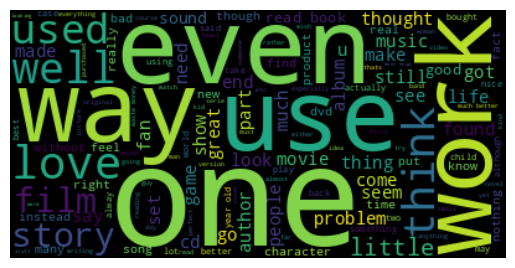

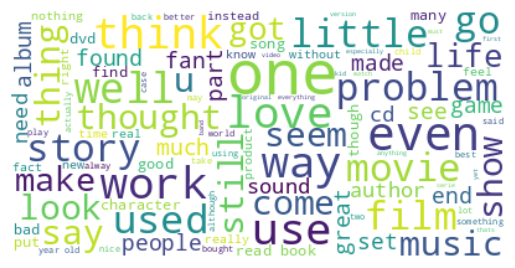

In [47]:
all_text = ' '.join(train["text"]).lower()

wordcloud = WordCloud().generate(all_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(all_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

**SENTIMENT ANALYSIS WITH Vader** :

Vader Sentiment Analyzer computes a sentiment score (compound) for each text. A positive score indicates positive sentiment, and a negative score indicates negative sentiment.
The label_text column creates a binary sentiment label: 1 (positive) or 0 (negative).

In [48]:
sent = SentimentIntensityAnalyzer()

train["score_title"] = train["title"].apply(lambda x: sent.polarity_scores(x)["compound"])
train["score_text"] = train["text"].apply(lambda x: sent.polarity_scores(x)["compound"])

test["score_title"] = test["title"].apply(lambda x: sent.polarity_scores(x)["compound"])
test["score_text"] = test["text"].apply(lambda x: sent.polarity_scores(x)["compound"])

In [49]:
train["label_title"] = train["title"].apply(lambda x: 1 if sent.polarity_scores(x)["compound"] > 0 else 0)
train["label_text"] = train["text"].apply(lambda x: 1 if sent.polarity_scores(x)["compound"] > 0 else 0)

test["label_title"] = test["title"].apply(lambda x: 1 if sent.polarity_scores(x)["compound"] > 0 else 0)
test["label_text"] = test["text"].apply(lambda x: 1 if sent.polarity_scores(x)["compound"] > 0 else 0)

In [50]:
train["label_text"].value_counts()

,count
label_text,
1,226120
0,73880


In [51]:
test["label_text"].value_counts()

,count
label_text,
1,75325
0,24675


In [52]:
train.head()

,title,text,score_title,score_text,label_title,label_text
2136295,making suit human skin hard work really perfec...,yes go ahead laugh others bought book know tru...,0.7755,0.9467,1,1
2620775,amazon allowed 6,wowthis movie classic family movie meansthere ...,0.1779,0.9393,1,1
1588872,thought apple user friendly,thought apple user friendly guess wrong actual...,0.4939,0.9231,1,1
3125694,helpful,bought book joining curve helped understand cu...,0.4215,0.6808,1,1
1668956,academically repugnant,first ten minute film passed slight sense bias...,0.0000,-0.3612,0,0


In [53]:
test.head()

,title,text,score_title,score_text,label_title,label_text
110227,useless tool novel writing,met author booksoftware writer conference 1999...,-0.1280,-0.5063,0,0
118016,load historical b,bought book several year ago worst 10 ever spe...,0.0000,-0.8126,0,0
180926,dont,two unit worked poorly tne start neither unit ...,0.0000,-0.0258,0,0
121412,cute,really liked mobiblue 1500 cube first great so...,0.4588,0.9621,1,1
128565,totally disappointed,trilogy recommended disturbed read 40 page fou...,-0.5256,-0.8860,0,0


**TEXT VECTORIZER**

In [54]:
y_train = train["label_text"]
X_train = train["text"]

In [55]:
y_test = test["label_text"]
X_test = test["text"]

**Text Vectorization :**

TF-IDF (Term Frequency-Inverse Document Frequency) converts text into numerical vectors. This highlights important words while downweighting frequent, less informative words.

In [56]:
vectorizer = TfidfVectorizer().fit(X_train)
x_train_tfidf = vectorizer.transform(X_train)
x_test_tfidf = vectorizer.transform(X_test)

**Modelling (Logistic Regression)**
Logistic Regression is a simple yet effective algorithm for binary classification problems like sentiment prediction.
The classification_report evaluates precision, recall, and F1-score for the model's predictions.

In [57]:
model = LogisticRegression().fit(x_train_tfidf,
                                 y_train)
y_predict = model.predict(x_test_tfidf)
print(classification_report(y_predict,
                            y_test))

              precision    recall  f1-score   support

           0       0.72      0.86      0.79     20707
           1       0.96      0.91      0.94     79293

    accuracy                           0.90    100000
   macro avg       0.84      0.89      0.86    100000
weighted avg       0.91      0.90      0.91    100000



**Evaluation and Predictions**


CROSS-VALIDATION : To ensures the model generalizes well to unseen data.


In [58]:
cross_val_score(model,
                x_test_tfidf,
                y_test,
                cv=5).mean()

0.87994

Predict Sentiment for a Random Review to
Demonstrates how the model predicts sentiment for individual reviews.

In [59]:
random_text = pd.Series(train["text"].sample(1).values)
new_text = CountVectorizer().fit(X_train).transform(random_text)
prediction = model.predict(new_text)
print(f'Text: {random_text[0]} \n Prediction: {prediction}')

Text: worst fondue chocolate ever bought instruction pack say melt microwave 2 min interval chocolate refused melt instead got even harder even added oil help wasted hour trying work chocolatethis milk chocolate total rip offi wont using rest 20 pound bought p sephra dark chocolate perfect milk chocolate rip 
 Prediction: [1]


In [60]:
out = pd.DataFrame(y_predict, columns = ["prediction"])

In [61]:
out.head(20)

,prediction
0,0
1,0
2,0
3,1
4,0
5,0
6,0
7,0
8,1
9,1
